In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import client_surveillance_jupyter

In [4]:
COMPANY_IDENTIFIER = ['ST']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C9-0000323-LIC,Retailer,MAKE YOUR MARK SF,True,Active,CA-04255,Retailer-Non-Storefront,c097c60c-3431-4fe0-8c1a-273da2d195bb,6cce2045-ccbe-485a-bc2b-45e8d3651e8a


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['C12-0000359-LIC', 'C9-0000323-LIC'], dtype=object)

In [9]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C12-0000359-LIC...
Earliest download summary: 2022-01-03
Latest download summary: 2022-07-17
Found bad download summary for license C12-0000359-LIC on date 2022-04-12
Found bad download summary for license C12-0000359-LIC on date 2022-03-11
Found bad download summary for license C12-0000359-LIC on date 2022-03-10
Found bad download summary for license C12-0000359-LIC on date 2022-03-09

Verifying download summaries for license C9-0000323-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-07-17
Found bad download summary for license C9-0000323-LIC on date 2022-04-12
Found bad download summary for license C9-0000323-LIC on date 2022-03-11
Found bad download summary for license C9-0000323-LIC on date 2022-03-10
Found bad download summary for license C9-0000323-LIC on date 2022-03-09

[FAILURE] Found a total of 8 bad download summaries


In [10]:
bad_download_history

defaultdict(list,
            {'C12-0000359-LIC': [datetime.date(2022, 4, 12),
              datetime.date(2022, 3, 11),
              datetime.date(2022, 3, 10),
              datetime.date(2022, 3, 9)],
             'C9-0000323-LIC': [datetime.date(2022, 4, 12),
              datetime.date(2022, 3, 11),
              datetime.date(2022, 3, 10),
              datetime.date(2022, 3, 9)]})

## Choose license numbers

In [11]:
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C9-0000323-LIC']

In [12]:
if COMPANY_IDENTIFIER == ['GRG']:
    license_numbers = ['C10-0000169-LIC']
elif COMPANY_IDENTIFIER == ['CSC']:
    license_numbers = ['C10-0000670-LIC']
license_numbers

['C9-0000323-LIC']

# License check

In [13]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C9-0000323-LIC,Retailer,MAKE YOUR MARK SF,True,Active,CA-04255,Retailer-Non-Storefront,c097c60c-3431-4fe0-8c1a-273da2d195bb,6cce2045-ccbe-485a-bc2b-45e8d3651e8a


In [14]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'CA'

In [15]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status','us_state']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]
retial_license_check_df


,license_number,license_category,is_current,license_status,us_state,license_check
0,C9-0000323-LIC,Retailer,True,Active,CA,YES


## Pull data

In [16]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)



company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [17]:
print(company_outgoing_transfer_packages_query)


		select
			case
				when company_deliveries.delivery_type = 'INCOMING_FROM_VENDOR' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'INCOMING_UNKNOWN' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'OUTGOING_UNKNOWN' then 'OUTGOING_TO_PAYOR'
				when company_deliveries.delivery_type = 'OUTGOING_TO_PAYOR' then 'OUTGOING_TO_PAYOR'
				else company_deliveries.delivery_type
			end as delivery_type,
			company_deliveries.license_number,
			metrc_transfers.manifest_number,
			metrc_transfers.created_date,
			metrc_deliveries.received_datetime,
			metrc_transfers.shipper_facility_license_number,
			metrc_transfers.shipper_facility_name,
			metrc_deliveries.recipient_facility_license_number,
			metrc_deliveries.recipient_facility_name,
			metrc_deliveries.shipment_type_name,
			metrc_deliveries.shipment_transaction_type,
			metrc_transfer_packages.package_id,
			metrc_transfer_packages.package_label,
			metrc_transfer_packages.type,
			metrc_tr

In [18]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C9-0000323-LIC'], dtype=object)

In [19]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C9-0000323-LIC'], dtype=object)

In [20]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C9-0000323-LIC'], dtype=object)

# pull repayment data (if any)

In [21]:
# fetch repayment history query
company_repayment_query = create_queries.create_company_repayment_history_query(COMPANY_IDENTIFIER)
company_repayment_data = pd.read_sql_query(company_repayment_query, engine)

In [22]:
company_repayment_data

,company_id,identifier,loan_id,loan_amount,outstanding_principal_balance,adjusted_maturity_date,last_settlement_date,total_paid,days_late_temp,days_late
0,c097c60c-3431-4fe0-8c1a-273da2d195bb,ST,a37a1b3a-0c8a-46dd-bf25-482159a06b0c,9820.00,9820.0,2022-08-09,None,NaN,-22,0
1,c097c60c-3431-4fe0-8c1a-273da2d195bb,ST,f510d289-9b05-4457-9994-986aff69beb9,15797.80,0.0,2022-03-14,2022-03-16,15797.80,2,2
2,c097c60c-3431-4fe0-8c1a-273da2d195bb,ST,3d22070f-de48-49fa-a09f-ab6f695072a6,3484.89,0.0,2022-03-14,2022-03-04,3484.89,-10,0
3,c097c60c-3431-4fe0-8c1a-273da2d195bb,ST,7500836d-d251-416d-9911-f30eb4bfd1b8,24567.50,0.0,2022-05-02,2022-05-23,24567.50,21,21
4,c097c60c-3431-4fe0-8c1a-273da2d195bb,ST,8b3ce12b-4a9c-43d7-8d9d-f2c4d9e9b918,12720.00,0.0,2022-06-06,2022-06-06,12720.00,0,0
5,c097c60c-3431-4fe0-8c1a-273da2d195bb,ST,50997f87-89a9-4f07-8cf0-f905de4c0cf3,12668.00,0.0,2022-07-11,2022-07-07,12668.00,-4,0


## Unknown transfer packages

In [23]:
unknown_package_count = client_surveillance_jupyter.check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[FAILURE] Found a total of 8 unknown transfer packages


8

## Receiver wholesale price coverage

In [24]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(5520, 31)

In [25]:
company_incoming_transfer_packages_dataframe.shape

(5721, 31)

In [26]:
rwp_coverage = client_surveillance_jupyter.check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


96.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [27]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [28]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [29]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C9-0000323-LIC'], dtype=object)

## Trxns missing incoming transfer packages

In [30]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = client_surveillance_jupyter.check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 1476 (1.2109477553163561%)
# transactions total: 121888


In [31]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2020-01    137
2020-02    184
2020-03     70
2020-04      8
2020-05      2
2022-03    145
2022-04    245
2022-05    182
2022-06     98
2022-07    140
dtype: int64

## Receipts missing metrc_sales_transactions

In [32]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [33]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 57787


In [34]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

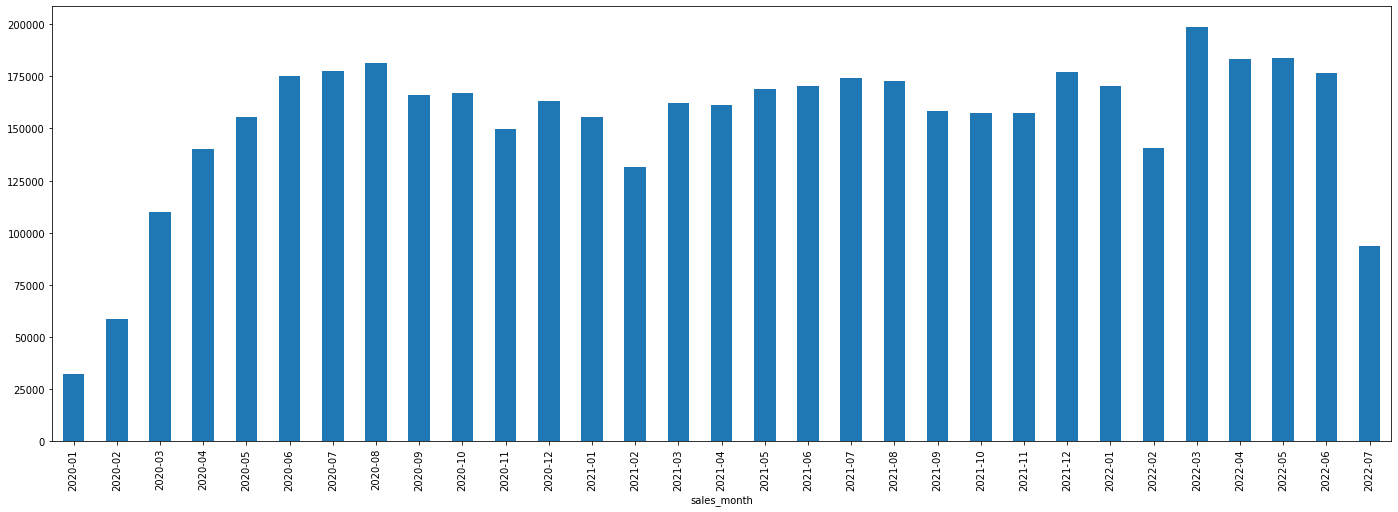

In [35]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

# Vendor churn

In [36]:
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-06-01'
VC_MONTH_LIST = ['2022-03-01','2022-04-01','2022-05-01','2022-06-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [37]:
churn,vc_matrix = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)


In [38]:
churn_short,vc_matrix_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)


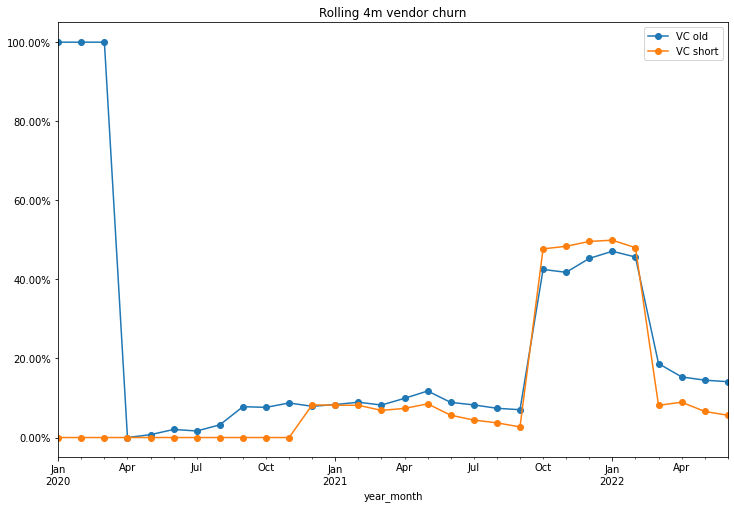

In [39]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [40]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 18018.0 from package ID: 12987653
min per unit incoming: 0.0003125 from package ID: 21032219



In [41]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,12987653,18018.0
1,17188048,200.0
2,11126902,100.0
3,23051173,100.0
4,23512310,100.0
5,19312711,100.0
6,19312713,100.0
7,21429497,100.0
8,21540906,100.0
9,13780106,100.0


In [42]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
5573,13406396,0.000400
5574,5363090,0.000400
5575,13406395,0.000400
5576,3105181,0.000357
5577,21032219,0.000313


In [44]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] >= 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming
3500,INCOMING_FROM_VENDOR,C9-0000323-LIC,0001766506,2021-04-03,2021-04-08 22:25:59+00:00,Wholesale,C11-0000586-LIC,JBTB HOLDINGS INC,C9-0000323-LIC,MAKE YOUR MARK SF INC,Wholesale Manifest,Wholesale,12987653,1A4060300008D22000163792,transfer,1A4060300008D22000160454,"191029BD, 191029BLJ, 191030BD, 20' #1, 20' #2,...",Accepted,False,False,Vape Cartridge (volume - each),STIIIZY - Blue Burst Pod - 1.0g,passed,630630.0,35.0,Each,630630.0,35.0,Each,NaN,None,18018.0


# COGS analysis

In [45]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] < 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [46]:
df_summary_simp,df_cogs_average_product = client_surveillance_jupyter.cogs_analysis(df_in,df_sales,'monthly',company_state)


In [47]:
df_summary_simp_uom,df_cogs_average_product_uom = client_surveillance_jupyter.cogs_analysis_uom(df_in,df_sales,'monthly',company_state)


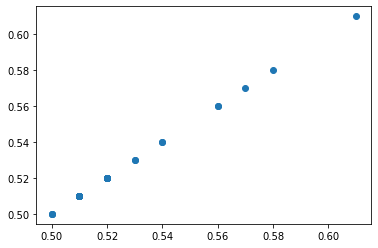

In [48]:
plt.scatter(df_summary_simp['margin_%'] ,df_summary_simp_uom['margin_%'] )

In [49]:
df_summary_simp

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01,2020-01,32006.67,14046.91,17959.76,0.56,819.0,77.0,742,0.86,948,36807.67,17839.58,18968.09,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.52,NaN,NaN,NaN,NaN
2020-02,2020-02,58493.48,25058.08,33435.40,0.57,1489.0,78.0,1411,0.89,1666,67267.50,31823.76,35443.75,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,0.83
2020-03,2020-03,109750.11,52557.54,57192.58,0.52,2758.0,36.0,2722,0.99,2794,126212.63,66748.07,59464.56,0.47,0.55,NaN,NaN,91662.52,0.50,NaN,NaN,0.47,0.50,NaN,NaN,0.88
2020-04,2020-04,139949.25,68316.73,71632.52,0.51,3514.0,0.0,3514,1.00,3522,160941.64,86762.24,74179.40,0.46,0.53,NaN,NaN,145932.34,0.49,NaN,NaN,0.46,0.49,NaN,NaN,0.28
2020-05,2020-05,155540.53,76684.73,78855.80,0.51,3890.0,0.0,3890,1.00,3892,178871.61,97389.61,81482.00,0.46,0.51,NaN,NaN,197558.99,0.46,NaN,NaN,0.46,0.46,NaN,NaN,0.11
2020-06,2020-06,175084.13,86453.78,88630.35,0.51,4138.0,0.0,4138,1.00,4138,201346.75,109796.30,91550.45,0.45,0.51,0.53,NaN,231455.24,0.46,0.48,NaN,0.45,0.46,0.48,NaN,0.13
2020-07,2020-07,177390.11,85920.88,91469.23,0.52,4284.0,0.0,4284,1.00,4284,203998.63,109119.51,94879.11,0.47,0.51,0.52,NaN,249059.39,0.46,0.47,NaN,0.47,0.46,0.47,NaN,0.01
2020-08,2020-08,181439.36,87586.08,93853.28,0.52,4353.0,0.0,4353,1.00,4353,208655.26,111234.32,97420.94,0.47,0.51,0.51,NaN,259960.74,0.46,0.46,NaN,0.47,0.46,0.46,NaN,0.02
2020-09,2020-09,166193.00,81380.56,84812.44,0.51,3931.0,0.0,3931,1.00,3931,191121.95,103353.31,87768.64,0.46,0.51,0.51,0.52,254887.52,0.46,0.46,0.48,0.46,0.46,0.46,0.48,-0.08


In [50]:
def cogs_analysis_fill_by_product_category(df_in:pd.DataFrame,df_inventory:pd.DataFrame,df_sales:pd.DataFrame,freq: str,state) -> pd.DataFrame:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")

    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")

    # total # trxns    
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    # per unit price by product category name
    average_incoming_product_category = df_in_price.groupby('product_category_name')['per_unit_incoming'].mean()
    df_avg_product_cat = pd.Series(average_incoming_product_category).to_frame()
    df_avg_product_cat = df_avg_product_cat.reset_index()
    df_avg_product_cat.rename(columns={'per_unit_incoming':'per_unit_product_cat'}, inplace=True)
    
    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]
    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxns by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    # merge with (cogs by product category name)
    df_cogs_average_product_cat = pd.merge(df_cogs_average_product, df_avg_product_cat, left_on='tx_product_category_name', right_on='product_category_name', how='left')
    df_cogs_average_product_cat['total_product_cat'] = df_cogs_average_product_cat['tx_quantity_sold'] * df_cogs_average_product_cat['per_unit_product_cat']
    df_cogs_null = df_cogs_average_product_cat[df_cogs_average_product_cat['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[(df_cogs_null['per_unit_product'].notnull())]
    df_cogs_product_null = df_cogs_average_product_cat[(df_cogs_average_product_cat['per_unit_incoming'].isnull())&(df_cogs_average_product_cat['per_unit_product'].isnull())]
    df_cogs_product_cat = df_cogs_product_null[df_cogs_product_null['per_unit_product_cat'].notnull()]
    
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # sum cogs filldown by product category name
    product_cat_sum = df_cogs_product_cat.groupby('date')['total_product_cat'].sum()
    df_product_cat_sum = pd.Series(product_cat_sum).to_frame()
    df_product_cat_sum = df_product_cat_sum.reset_index()
    df_product_cat_sum.rename(columns={'total_product_cat':'product_cat_sum'}, inplace=True)
    # count # of trxn filldown by product category name
    product_cat_count = df_cogs_product_cat.groupby('date')['total_product_cat'].count()
    df_product_cat_count = pd.Series(product_cat_count).to_frame()
    df_product_cat_count = df_product_cat_count.reset_index()
    df_product_cat_count.rename(columns={'total_product_cat':'product_cat_count'}, inplace=True)
    df_cogs_product_cat_df = pd.merge(df_product_cat_sum, df_product_cat_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_product_cat_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    df_summary['product_cat_sum'] = df_summary['product_cat_sum'].fillna(0)
    df_summary['product_cat_count'] = df_summary['product_cat_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs + by product category name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum'] + df_summary['product_cat_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count + by product category count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count'] + df_summary['product_cat_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','product_cat_count','total_count','count_incoming', 'coverage']]
    #df_summary_simp.index = df_summary_simp.date
    
    
        # tax treatment
    df_summary_simp["revenue_after_tax"] = df_summary_simp["revenue"] * 1.15
    df_summary_simp["cogs_after_tax"] = df_summary_simp["cogs"] * 1.2625
    df_summary_simp["margin_$_after_tax"] = (
        df_summary_simp["revenue_after_tax"] - df_summary_simp["cogs_after_tax"]
    )
    df_summary_simp["margin_%_after_tax"] = (
        df_summary_simp["margin_$_after_tax"] / df_summary_simp["revenue_after_tax"]
    )
    # past quarter pre tax
    df_summary_simp["gm_past_quarter"] = (
        df_summary_simp[["margin_%"]].rolling(3).mean().values
    )
    df_summary_simp["gm_past_2quarters"] = (
        df_summary_simp[["margin_%"]].rolling(6).mean().values
    )
    df_summary_simp["gm_past_3quarters"] = (
        df_summary_simp[["margin_%"]].rolling(9).mean().values
    )
    df_summary_simp["sum_cogs_past_3months"] = (
        df_summary_simp[["cogs"]].rolling(3).sum().values
    )
    # past quarter after tax
    df_summary_simp["gm_past_quarter_after_tax"] = (
        df_summary_simp[["margin_%_after_tax"]].rolling(3).mean().values
    )
    df_summary_simp["gm_past_2quarters_after_tax"] = (
        df_summary_simp[["margin_%_after_tax"]].rolling(6).mean().values
    )
    df_summary_simp["gm_past_3quarters_after_tax"] = (
        df_summary_simp[["margin_%_after_tax"]].rolling(9).mean().values
    )
    # revenue change
    # df_summary_simp['revenue_change'] = df_summary_simp['revenue'].pct_change()

    if state == "CA":
        df_summary_simp["gm_final"] = df_summary_simp["margin_%_after_tax"]

        df_summary_simp["gm_past_quarter_final"] = df_summary_simp[
            "gm_past_quarter_after_tax"
        ]
        df_summary_simp["gm_past_2quarters_final"] = df_summary_simp[
            "gm_past_2quarters_after_tax"
        ]
        df_summary_simp["gm_past_3quarters_final"] = df_summary_simp[
            "gm_past_3quarters_after_tax"
        ]
    else:
        df_summary_simp["gm_final"] = df_summary_simp["margin_%"]
        df_summary_simp["gm_past_quarter_final"] = df_summary_simp["gm_past_quarter"]
        df_summary_simp["gm_past_2quarters_final"] = df_summary_simp[
            "gm_past_2quarters"
        ]
        df_summary_simp["gm_past_3quarters_final"] = df_summary_simp[
            "gm_past_3quarters"
        ]
    df_summary_simp["revenue_change"] = df_summary_simp["revenue"].pct_change().values
    df_summary_simp.index = df_summary_simp.date
    df_summary_simp = df_summary_simp.round(2)
    
    
    return df_summary_simp,df_cogs_average_product_cat




In [51]:
df_summary_simp_cat_monthly,df_cogs_average_product_cat_monthly = cogs_analysis_fill_by_product_category(df_in,df_inventory,df_sales,'monthly',company_state)




In [52]:
df_summary_simp_cat_monthly

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,product_cat_count,total_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01,2020-01,32006.67,15701.33,16305.34,0.51,948.0,77.0,129.0,948,742,1.0,36807.67,19822.93,16984.74,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,NaN,NaN,NaN,NaN
2020-02,2020-02,58493.48,27403.23,31090.25,0.53,1666.0,78.0,177.0,1666,1411,1.0,67267.50,34596.58,32670.92,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49,NaN,NaN,NaN,0.83
2020-03,2020-03,109750.11,53094.10,56656.01,0.52,2794.0,36.0,36.0,2794,2722,1.0,126212.63,67031.30,59181.33,0.47,0.52,NaN,NaN,96198.67,0.47,NaN,NaN,0.47,0.47,NaN,NaN,0.88
2020-04,2020-04,139949.25,68401.67,71547.58,0.51,3522.0,0.0,8.0,3522,3514,1.0,160941.64,86357.11,74584.52,0.46,0.52,NaN,NaN,148899.01,0.47,NaN,NaN,0.46,0.47,NaN,NaN,0.28
2020-05,2020-05,155540.53,76696.57,78843.96,0.51,3892.0,0.0,2.0,3892,3890,1.0,178871.61,96829.42,82042.19,0.46,0.51,NaN,NaN,198192.34,0.46,NaN,NaN,0.46,0.46,NaN,NaN,0.11
2020-06,2020-06,175084.13,86453.78,88630.35,0.51,4138.0,0.0,0.0,4138,4138,1.0,201346.75,109147.90,92198.85,0.46,0.51,0.51,NaN,231552.03,0.46,0.47,NaN,0.46,0.46,0.47,NaN,0.13
2020-07,2020-07,177390.11,85920.88,91469.23,0.52,4284.0,0.0,0.0,4284,4284,1.0,203998.63,108475.11,95523.52,0.47,0.51,0.51,NaN,249071.23,0.46,0.47,NaN,0.47,0.46,0.47,NaN,0.01
2020-08,2020-08,181439.36,87586.08,93853.28,0.52,4353.0,0.0,0.0,4353,4353,1.0,208655.26,110577.43,98077.83,0.47,0.51,0.51,NaN,259960.74,0.47,0.46,NaN,0.47,0.47,0.46,NaN,0.02
2020-09,2020-09,166193.00,81380.56,84812.44,0.51,3931.0,0.0,0.0,3931,3931,1.0,191121.95,102742.96,88378.99,0.46,0.51,0.51,0.51,254887.52,0.47,0.46,0.47,0.46,0.47,0.46,0.47,-0.08


# Revenue change vs state

In [53]:
if COMPANY_IDENTIFIER == ['NECC']:
    a = client_surveillance_jupyter.calculate_quarterly_sum_gmv_ma_short(df_summary_simp)
    a

In [54]:
if COMPANY_IDENTIFIER == ['NECC']:
    round(a.dropna()['total'].sum(),2)

In [55]:
a = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp)
round(a.dropna()['total'].sum(),2)

12.6

In [56]:
a

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,200250.26,NaN,NaN,NaN,NaN,10,NaN
2020Q2,470573.91,1.349929,NaN,NaN,NaN,10,NaN
2020Q3,525022.47,0.115707,NaN,NaN,NaN,10,NaN
2020Q4,480140.87,-0.085485,0.17,0.04,-0.255485,-5,-0.2
2021Q1,449252.90,-0.064331,-0.05,0.28,-0.014331,0,0.0
2021Q2,500895.54,0.114952,0.02,0.52,0.094952,10,5.2
2021Q3,505783.12,0.009758,-0.11,0.76,0.119758,10,7.6
2021Q4,492193.28,-0.026869,0.00,1.00,-0.026869,0,0.0


# Inventory

In [57]:
today = date.today()
today

datetime.date(2022, 7, 18)

In [58]:
COMPANY_IDENTIFIER

['ST']

In [59]:
license_numbers

['C9-0000323-LIC']

In [60]:
df_inventory_license = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory,license_numbers,today)

In [61]:
df_inventory_license

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-07-18,43977.19,55851.03,683,725,0.94,[C9-0000323-LIC],MAKE YOUR MARK SF INC


In [62]:
df_inventory_license_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales,df_inventory,license_numbers,today)

In [63]:
df_inventory_license_msrp

,date,value,total_incoming,total,coverage,license,legal_name
0,2022-07-18,110166.43,703,725,0.97,[C9-0000323-LIC],MAKE YOUR MARK SF INC


In [64]:
df_inventory_fresh,_ = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory,license_numbers,today)

In [65]:
df_inventory_fresh

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-07-18,33419.83,42443.18,303,326,0.93,[C9-0000323-LIC],MAKE YOUR MARK SF INC


In [167]:
def calculate_inventory_valuation_by_group(
    incoming_transfer_df, inventory_df, license_list, today_date
):
    # legal name
    legal_name = incoming_transfer_df[
        incoming_transfer_df["license_number"].isin(license_list)
    ]["recipient_facility_name"].values[0]
    # process df_in and df_sales
    incoming_transfer_df["per_unit_incoming"] = (
        incoming_transfer_df["shipper_wholesale_price"]
        / incoming_transfer_df["shipped_quantity"]
    )
    incoming_transfer_df_price = incoming_transfer_df[
        incoming_transfer_df["shipper_wholesale_price"].notnull()
    ]
    # by package id
    average_incoming_package_id = incoming_transfer_df_price.groupby(["package_id"])[
        "per_unit_incoming"
    ].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # by product
    average_incoming_product = incoming_transfer_df_price.groupby(["product_name"])[
        "per_unit_incoming"
    ].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(
        columns={"per_unit_incoming": "per_unit_product"}, inplace=True
    )
    inventory_df = get_valid_inventory_df(inventory_df)

    # inventory aging grouping
    inventory_df = inventory_df.reset_index(drop=True)
    inventory_df["age"] = [
        today_date - inventory_df["packaged_date"][i] for i in range(len(inventory_df))
    ]
    inventory_df["age_int"] = [
        inventory_df["age"][i] / numpy.timedelta64(1, "D")
        for i in range(len(inventory_df))
    ]
    inventory_df['group'] = inventory_df.apply(lambda row: group_inventory_df(180,270,row['age_int']),axis = 1)
    
    # calculate inventory
    df_inventory_incoming = pd.merge(
        inventory_df,
        df_avg_incoming_price,
        left_on=["package_id"],
        right_on=["package_id"],
        how="left",
    )

    df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
    df_inventory_incoming["total_price"] = (df_inventory_incoming["quantity"] * df_inventory_incoming["per_unit_incoming"])
    df_inventory_incoming_summary = df_inventory_incoming[['group','total_price']].groupby('group').sum().reset_index()
    df_inventory_incoming_summary.columns = ['group','total_from_pkg']
    
    df_inv_null = df_inventory_incoming[
        df_inventory_incoming["per_unit_incoming"].isnull()
    ]
    df_inv_product = pd.merge(
        df_inv_null,
        df_avg_product,
        left_on=["product_name"],
        right_on=["product_name"],
        how="left",
    )
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product["per_unit_product"].notnull()]
    df_inv_product_price["total_price"] = (df_inv_product_price["quantity"] * df_inv_product_price["per_unit_product"])
    df_inv_product_price_summary = df_inv_product_price[['group','total_price']].groupby('group').sum().reset_index()
    df_inv_product_price_summary.columns = ['group','total_from_prod']
    df_inv_group_merged = df_inventory_incoming_summary.merge(df_inv_product_price_summary,how = 'outer',on = 'group')
    df_inv_group_merged = df_inv_group_merged.fillna(0)
    df_inv_group_merged['total_value'] = df_inv_group_merged['total_from_pkg'] + df_inv_group_merged['total_from_prod']
    # inventory valuation by group pre-tax
    inventory_value_fresh = df_inv_group_merged[df_inv_group_merged['group'] == 'fresh']['total_value'].values[0]
    
    inventory_value_stale = df_inv_group_merged[df_inv_group_merged['group'] == 'stale']['total_value'].values[0]
    
    inventory_value_bad = df_inv_group_merged[df_inv_group_merged['group'] == 'bad']['total_value'].values[0]
    
    #inventory valuation by group post-tax
    inventory_value_fresh_after_tax = inventory_value_fresh * 1.2625
    inventory_value_stale_after_tax = inventory_value_stale * 1.2625
    inventory_value_bad_after_tax = inventory_value_bad * 1.2625
    
    # total valuation pre-tax
    inventory_value = df_inventory_incoming["total_price"].sum()
    inventory_product_value = df_inv_product_price["total_price"].sum()
    total_inv_value = inventory_product_value + inventory_value
    
    # total valuation post-tax
    total_inv_value_after_tax = (inventory_product_value + inventory_value) * 1.2625

    # count and coverage
    inv_count_product = df_inv_product_price["per_unit_product"].count()
    inv_count_incoming = df_inventory_incoming["per_unit_incoming"].count()
    inv_count_total = df_inventory_incoming["quantity"].count()
    inv_total_incoming = inv_count_product + inv_count_incoming
    inventory_coverage = inv_total_incoming / inv_count_total
    # prepare data
    data = [
        [today_date],
        [round(total_inv_value, 2)],
        [round(total_inv_value_after_tax, 2)],
        #grouping
        [round(inventory_value_fresh, 2)],
        [round(inventory_value_fresh_after_tax, 2)],
        [round(inventory_value_stale, 2)],
        [round(inventory_value_stale_after_tax, 2)],
        [round(inventory_value_bad, 2)],
        [round(inventory_value_bad_after_tax, 2)],
        [inv_total_incoming],
        [inv_count_total],
        [round(inventory_coverage, 2)],
        [license_list],
        [legal_name],
    ]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = [
        "date",
        "value",
        "value_after_tax",
        "fresh value",
        "fresh value after tax",
        "stale value",
        "stale value after tax",
        "bad value",
        "bad value after tax", 
        "total_incoming",
        "total",
        "coverage",
        "license",
        "legal_name",
    ]
    return df_inventory_license, inventory_df
                                            

In [111]:
def get_valid_inventory_df(inventory_data):
    #exclude trade samples
    inventory_data = inventory_data[~inventory_data['is_trade_sample']]
    #exclude quantity zero packages
    inventory_data = inventory_data[inventory_data['quantity'] > 0]
    return inventory_data

In [104]:
def group_inventory_df(fresh_cutoff,stale_cutoff,item_age):
    if item_age <= fresh_cutoff:
        group = 'fresh'
    elif fresh_cutoff < item_age <= stale_cutoff:
        group = 'stale'
    else:
        group = 'bad'
    return group

In [168]:
df_inventory_by_group,_ = calculate_inventory_valuation_by_group(df_in,df_inventory,license_numbers,today)



In [169]:
df_inventory_by_group

,date,value,value_after_tax,fresh value,fresh value after tax,stale value,stale value after tax,bad value,bad value after tax,total_incoming,total,coverage,license,legal_name
0,2022-07-18,43977.19,55521.2,39230.63,49528.67,1755.83,2216.74,2990.72,3775.78,683,725,0.94,[C9-0000323-LIC],MAKE YOUR MARK SF INC


# Quantity based inventory TO

In [ ]:
df_inventory.head()

In [ ]:
inventory_q = df_inventory[['package_id','unit_of_measure','quantity']].groupby(['package_id','unit_of_measure']).sum()



In [ ]:
inventory_q = inventory_q.reset_index()
inventory_q

In [ ]:
df_sales_3m = df_sales[df_sales['sales_month'] >= '2022-03']

In [ ]:
sales_q = df_sales_3m[['tx_package_id','tx_unit_of_measure','tx_quantity_sold']].groupby(['tx_package_id','tx_unit_of_measure']).sum()
sales_q = sales_q.reset_index()


In [ ]:
j = inventory_q.merge(sales_q,how = 'left',left_on = ['package_id','unit_of_measure'],right_on = ['tx_package_id','tx_unit_of_measure'])



In [ ]:
j['to'] = j['tx_quantity_sold'] / j['quantity'] * 4

In [ ]:
j[j['to'] >= 50]

In [ ]:
j['to'].describe()

# Repayment score

In [ ]:
company_repayment_data

In [ ]:
company_repayment_data_due = company_repayment_data[company_repayment_data['adjusted_maturity_date'] < today]

In [ ]:
company_repayment_data_due


In [ ]:
company_repayment_data_due['weight'] = company_repayment_data_due['loan_amount'] / sum(company_repayment_data_due['loan_amount'])

In [ ]:
len(company_repayment_data_due)

In [ ]:
if len(company_repayment_data_due) == 0:
    weighted_dpd = numpy.nan
else:
    weighted_dpd = sum(company_repayment_data_due['days_late'] * company_repayment_data_due['weight'])

    

In [ ]:
weighted_dpd

In [ ]:
repayment_score = client_surveillance_jupyter.get_short_repayment_score(weighted_dpd)
repayment_score

# Create Template: updated

In [ ]:
current_month = '2022-05'
full_score = 45

In [ ]:
license_numbers

In [ ]:
template_new_ = client_surveillance_jupyter.create_template_update(a,df_summary_simp,df_inventory_license,df_inventory_license_msrp,df_inventory_fresh,churn_short,retial_license_check_df,license_numbers,company_state,current_month)



In [ ]:
template_new_

# Output data 

In [ ]:
license_numbers

## others

In [ ]:
# for only 1 license
license_number = license_numbers[0]
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



In [ ]:
# multiple licenses
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today)  +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_rev_change_vs_state.csv')
#retial_license_check_df



# Appendix

In [ ]:
# def calculate_quarterly_sum_gmv_ma_short(cogs_analysis_df):

#     gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-02')][['revenue_change']]
#     gmv_df['sum_gmv_change_ma'] = [-0.07,0.09,-0.11,0.02]
#     gmv_df['weight'] = [0.76,0.84,0.92,1]
#     gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
#     gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
#     gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
#     gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
#     return gmv_df
    